# Sensitivity with systematics

#### Exercise
* Implement the detector response in the model function
* Calculate a covariance matrix for a variation of the deadlayer
* Use the covariance to calculate the sensitivity impact compared to the statistical sensitivity in a contour plot

In [5]:
import numpy as np
import plotInterface as pi; pi.init()
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.integrate import quad
from scipy.optimize import curve_fit
import scipy.stats as stats

from spectrum import *
import trmodel.pkg_detector.model_detector as det
from trmodel.lib.binning import binning

### Settings


In [27]:
# Statistics
measTime = 3*365*24*60*60   # 3 years
rate     = 1e9              # total rate at detector
nEvents  = rate*measTime    # expected dataset size ~10^16

# Binning
nBins       = 400
eBinEdges   = np.linspace(0,40000,nBins+1)
eBinCenters = (eBinEdges[:-1]+eBinEdges[1:])/2

print(f'Number of events: {nEvents:e}')

# Deadlayer variation (THIS IS NEW!)
dl_val = 58
dl_err = dl_val*0.01 # Assume 1% Uncertainty

Number of events: 9.460800e+16


### The model

In [12]:
angleBins = binning(0,1,25)
det.init(angleBins,mcdet_ftype='npy',mcdet_NEbin=400,cs_implementation='1D',
        qe_backscattering = True,
        charge_sharing    = False,
        fano_noise        = False)

def model(energyBinEdges, amplitude, Epae=0, mSterile=0, sin2theta=0, deadlayer=55):
    
    # define function for bin integration
    spec = lambda e: diffspec_mixed(e-Epae, mSterile=mSterile, sin2theta=sin2theta)
    
    # integrate over bins
    binnedSpec = integrate_over_bins(spec,energyBinEdges)
    
    # normalize to amplitude
    binnedSpec = amplitude*binnedSpec/binnedSpec.sum()
    
    # get backscattering + deadlayer response for incidence angle = 0°
    resp2D,resp3D = det.get_response_matrix(det_lambda=deadlayer)
    resp = resp3D[-1] # here we take only the component of the 3D matrix which corresponds to 0° incidence angle
    
    # apply response
    binnedSpec = np.dot(resp.T,binnedSpec)
    
    return binnedSpec

gen_binning_w binning(nbin=11, vmin=9.5, vmax=20.5)
initialize detector model with (25, 400, 400) bins


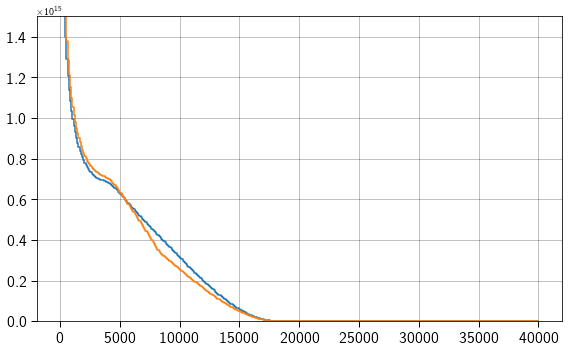

In [22]:
# evaluate model once
yData = model(eBinEdges, nEvents)

# plot as step histogram
plt.step(eBinCenters,yData)
plt.step(eBinCenters,model(eBinEdges, nEvents, 0, 10000, 0.3))

pi.plotty(ylim=[0,1.5e15])

### Covariance matrices

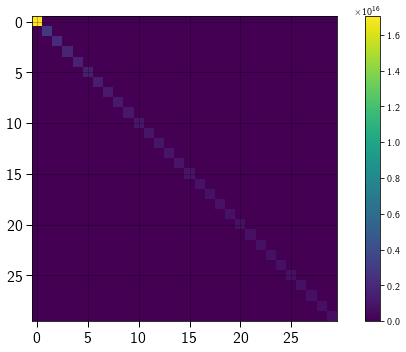

In [25]:
# calculate covairance matrix for statistical error
covStat = np.ones((nBins,nBins)) # initialize with ones to ensure inversibility
for i in range(nBins):
    covStat[i][i] = yData[i]

# for convenience also 1d error array for satstistics
yErr = np.sqrt(yData)

# show matrix
plt.imshow(covStat[0:30,0:30])
plt.colorbar()
pi.plotty()

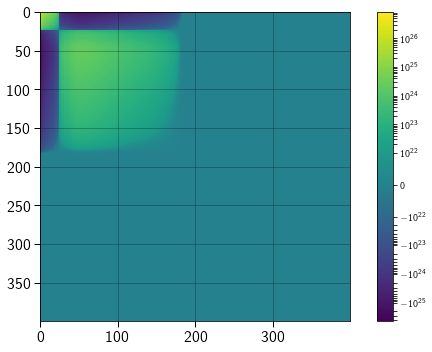

In [36]:
nExp = 50

deadlayers = np.random.normal(dl_val, dl_err, size=nExp)

data = np.zeros((nBins,nExp))
for i in range(nExp):
    data[:,i] = model(eBinEdges, nEvents, 0, 0, 0, deadlayers[i])

covSys = np.cov(data)

# show matrix
plt.imshow(covSys, norm=colors.SymLogNorm(1e22,base=10))
plt.colorbar()
pi.plotty()

### Chisquare grid calculation 

In [39]:
# define grid over mixing angles and sterile masses
mixings = np.logspace(-5,-9,20)
masses  = np.linspace(0,ENDPOINT,20)

# invert covariance matrix
covInvStat = np.linalg.inv(covStat)
covInvSys  = np.linalg.inv(covStat+covSys)

# calculate chisquare over grid
chisquareStat = np.zeros((len(mixings),len(masses)))
chisquareSys  = np.zeros((len(mixings),len(masses)))
for i,ms in enumerate(masses):
    for j,s2t in enumerate(mixings):
        
        # evealuate model for fixed parameters
        yModel = model(eBinEdges, nEvents, mSterile=ms, sin2theta=s2t)
        
        # define local fit model function where normalisation can be varied
        def fitmodel(x,norm):    
            return norm*yModel
        
        # fit the normalisation
        par, cov = curve_fit(fitmodel,eBinCenters,yData,sigma=yErr,p0=[1.0])
        
        # evaluate fitmodel for fitted normalisation
        yFit = fitmodel(eBinCenters,*par)
        
        # calculate chisquare
        yResidual = yData - yFit        
        chisquareStat[j][i] = yResidual.dot(covInvStat.dot(yResidual))
        chisquareSys[j][i]  = yResidual.dot(covInvSys.dot(yResidual))

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:461: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Exclusion / Sensitivity plot

Critical value for 90% confidence: 4.605170185988092


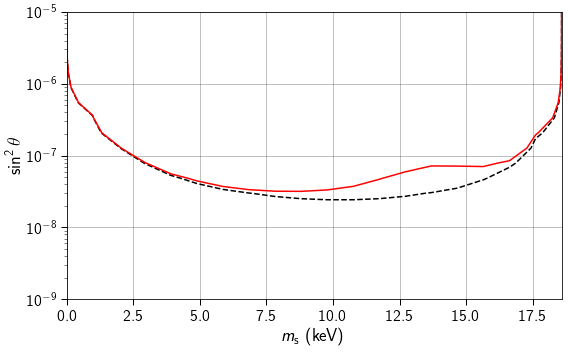

In [40]:
# critical chisquare value for 90% confidence for 2 parameters (here: mass, mixing)
chiSquareCrit = stats.chi2.ppf(0.9, df=2)
print(f'Critical value for 90% confidence: {chiSquareCrit}')

# plot 90% exclusion contours
plt.contour(masses/1000, mixings, chisquareStat, 
            levels=[chiSquareCrit], colors='k', linestyles='dashed')
plt.contour(masses/1000, mixings, chisquareSys, 
            levels=[chiSquareCrit], colors='r')

# show plot with labels
pi.plotty(xlabel=r'$m_\mathrm{s}$ (keV)', ylabel=r'$\sin^2\theta$',log='y')

### Using post acceleration

gen_binning_w binning(nbin=11, vmin=9.5, vmax=20.5)
initialize detector model with (25, 400, 400) bins


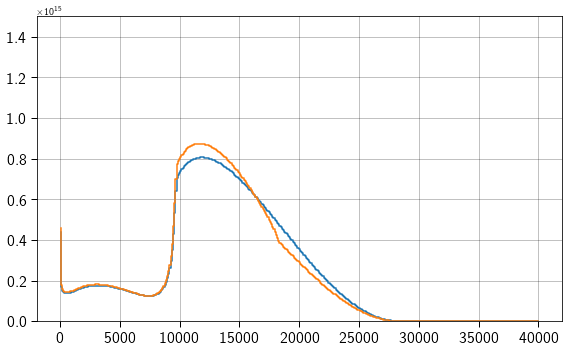

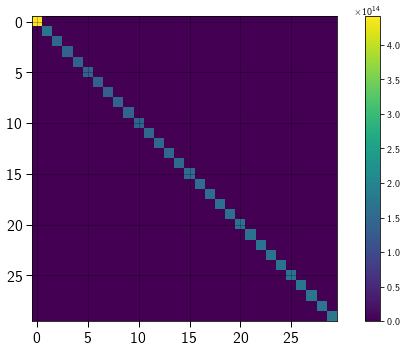

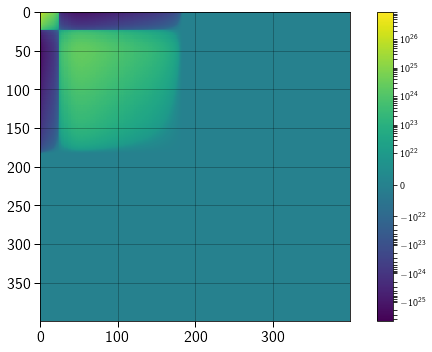

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:461: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Critical value for 90% confidence: 4.605170185988092


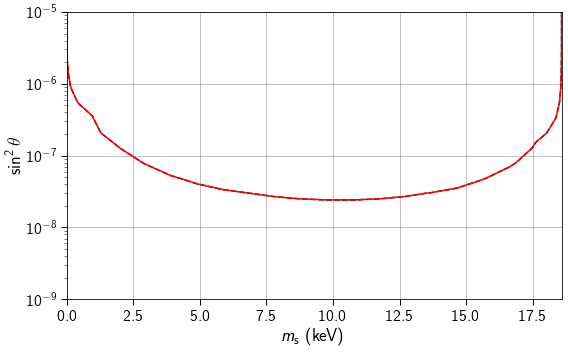

In [42]:
angleBins = binning(0,1,25)
det.init(angleBins,mcdet_ftype='npy',mcdet_NEbin=400,cs_implementation='1D',
        qe_backscattering = True,
        charge_sharing    = False,
        fano_noise        = False)

def model(energyBinEdges, amplitude, Epae=10000, mSterile=0, sin2theta=0, deadlayer=55):
    
    # define function for bin integration
    spec = lambda e: diffspec_mixed(e-Epae, mSterile=mSterile, sin2theta=sin2theta)
    
    # integrate over bins
    binnedSpec = integrate_over_bins(spec,energyBinEdges)
    
    # normalize to amplitude
    binnedSpec = amplitude*binnedSpec/binnedSpec.sum()
    
    # get backscattering + deadlayer response for incidence angle = 0°
    resp2D,resp3D = det.get_response_matrix(det_lambda=deadlayer)
    resp = resp3D[-1] # here we take only the component of the 3D matrix which corresponds to 0° incidence angle
    
    # apply response
    binnedSpec = np.dot(resp.T,binnedSpec)
    
    return binnedSpec

# evaluate model once
yData = model(eBinEdges, nEvents)

# plot as step histogram
plt.step(eBinCenters,yData)
plt.step(eBinCenters,model(eBinEdges, nEvents, 10000, 10000, 0.3))

pi.plotty(ylim=[0,1.5e15])

# calculate covairance matrix for statistical error
covStat = np.ones((nBins,nBins)) # initialize with ones to ensure inversibility
for i in range(nBins):
    covStat[i][i] = yData[i]

# for convenience also 1d error array for satstistics
yErr = np.sqrt(yData)

# show matrix
plt.imshow(covStat[0:30,0:30])
plt.colorbar()
pi.plotty()


nExp = 50

deadlayers = np.random.normal(dl_val, dl_err, size=nExp)

data = np.zeros((nBins,nExp))
for i in range(nExp):
    data[:,i] = model(eBinEdges, nEvents, 0, 0, 0, deadlayers[i])

covSys = np.cov(data)

# show matrix
plt.imshow(covSys, norm=colors.SymLogNorm(1e22,base=10))
plt.colorbar()
pi.plotty()

# define grid over mixing angles and sterile masses
mixings = np.logspace(-5,-9,20)
masses  = np.linspace(0,ENDPOINT,20)

# invert covariance matrix
covInvStat = np.linalg.inv(covStat)
covInvSys  = np.linalg.inv(covStat+covSys)

# calculate chisquare over grid
chisquareStat = np.zeros((len(mixings),len(masses)))
chisquareSys  = np.zeros((len(mixings),len(masses)))
for i,ms in enumerate(masses):
    for j,s2t in enumerate(mixings):
        
        # evealuate model for fixed parameters
        yModel = model(eBinEdges, nEvents, mSterile=ms, sin2theta=s2t)
        
        # define local fit model function where normalisation can be varied
        def fitmodel(x,norm):    
            return norm*yModel
        
        # fit the normalisation
        par, cov = curve_fit(fitmodel,eBinCenters,yData,sigma=yErr,p0=[1.0])
        
        # evaluate fitmodel for fitted normalisation
        yFit = fitmodel(eBinCenters,*par)
        
        # calculate chisquare
        yResidual = yData - yFit        
        chisquareStat[j][i] = yResidual.dot(covInvStat.dot(yResidual))
        chisquareSys[j][i]  = yResidual.dot(covInvSys.dot(yResidual))

# critical chisquare value for 90% confidence for 2 parameters (here: mass, mixing)
chiSquareCrit = stats.chi2.ppf(0.9, df=2)
print(f'Critical value for 90% confidence: {chiSquareCrit}')

# plot 90% exclusion contours
plt.contour(masses/1000, mixings, chisquareStat, 
            levels=[chiSquareCrit], colors='k', linestyles='dashed')
plt.contour(masses/1000, mixings, chisquareSys, 
            levels=[chiSquareCrit], colors='r')

# show plot with labels
pi.plotty(xlabel=r'$m_\mathrm{s}$ (keV)', ylabel=r'$\sin^2\theta$',log='y')